In [4]:
# import matplotlib.pyplot as plt
# import numpy as np
# from tensorflow import keras
# import os

# (train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
# print('loaded data')

# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sendal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# print('class names')

# train_images = train_images / 255.0
# test_images = test_images /255.0
# print('resized images')

# model = keras.Sequential([
#     keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(10, activation='softmax'),
# ])
# print('created model')

# initial_learning_rate = 0.001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.98, staircase=True
# )
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = model.fit(train_images,
#                     train_labels,
#                     epochs=4,
#                     validation_data=(test_images, test_labels))

# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print('Test accuracy:', test_acc)

# predictions = model.predict(test_images)

# fig = plt.figure(figsize=(8,8))

# for i in range(16):
#     ax = fig.add_subplot(4, 4, i+1)
#     ax.imshow(test_images[i])
#     predicted_label = np.argmax(predictions[i])
#     true_label = test_labels[i]
#     ax.set_title("Predicted: {}\nTrue:{}".format(class_names[predicted_label], class_names[true_label]))
#     ax.axis('off')

# plt.show()

# Imports

In [5]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
#from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.layers.experimental import preprocessing

# Model Architecture
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

# System libraries
from pathlib import Path
import os.path

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns

# Metrics
#from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model Hypertunning
import keras_tuner as kt

In [6]:
train_path = './archive/train'
test_path = './archive/test'
valid_path = './archive/valid'

In [7]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

# data augmentation for validation
valid_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [8]:
images_size = 224
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)


# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')


# Create a generator for validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


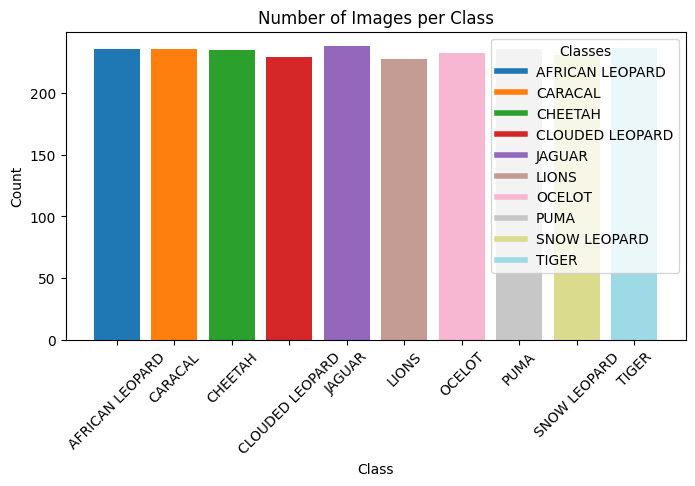

In [9]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

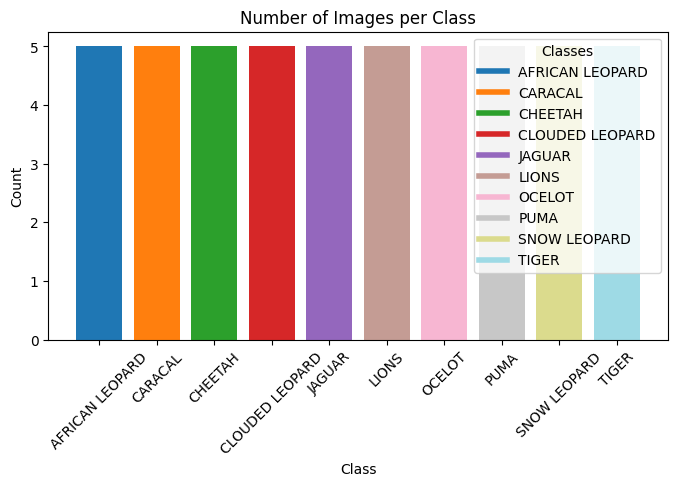

In [10]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

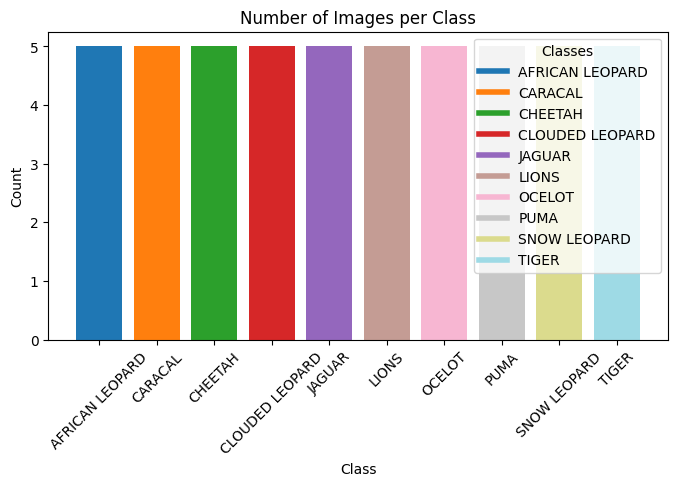

In [11]:
# Get the class labels
class_labels = list(valid_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(valid_generator)):
    batch_data, batch_labels = valid_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

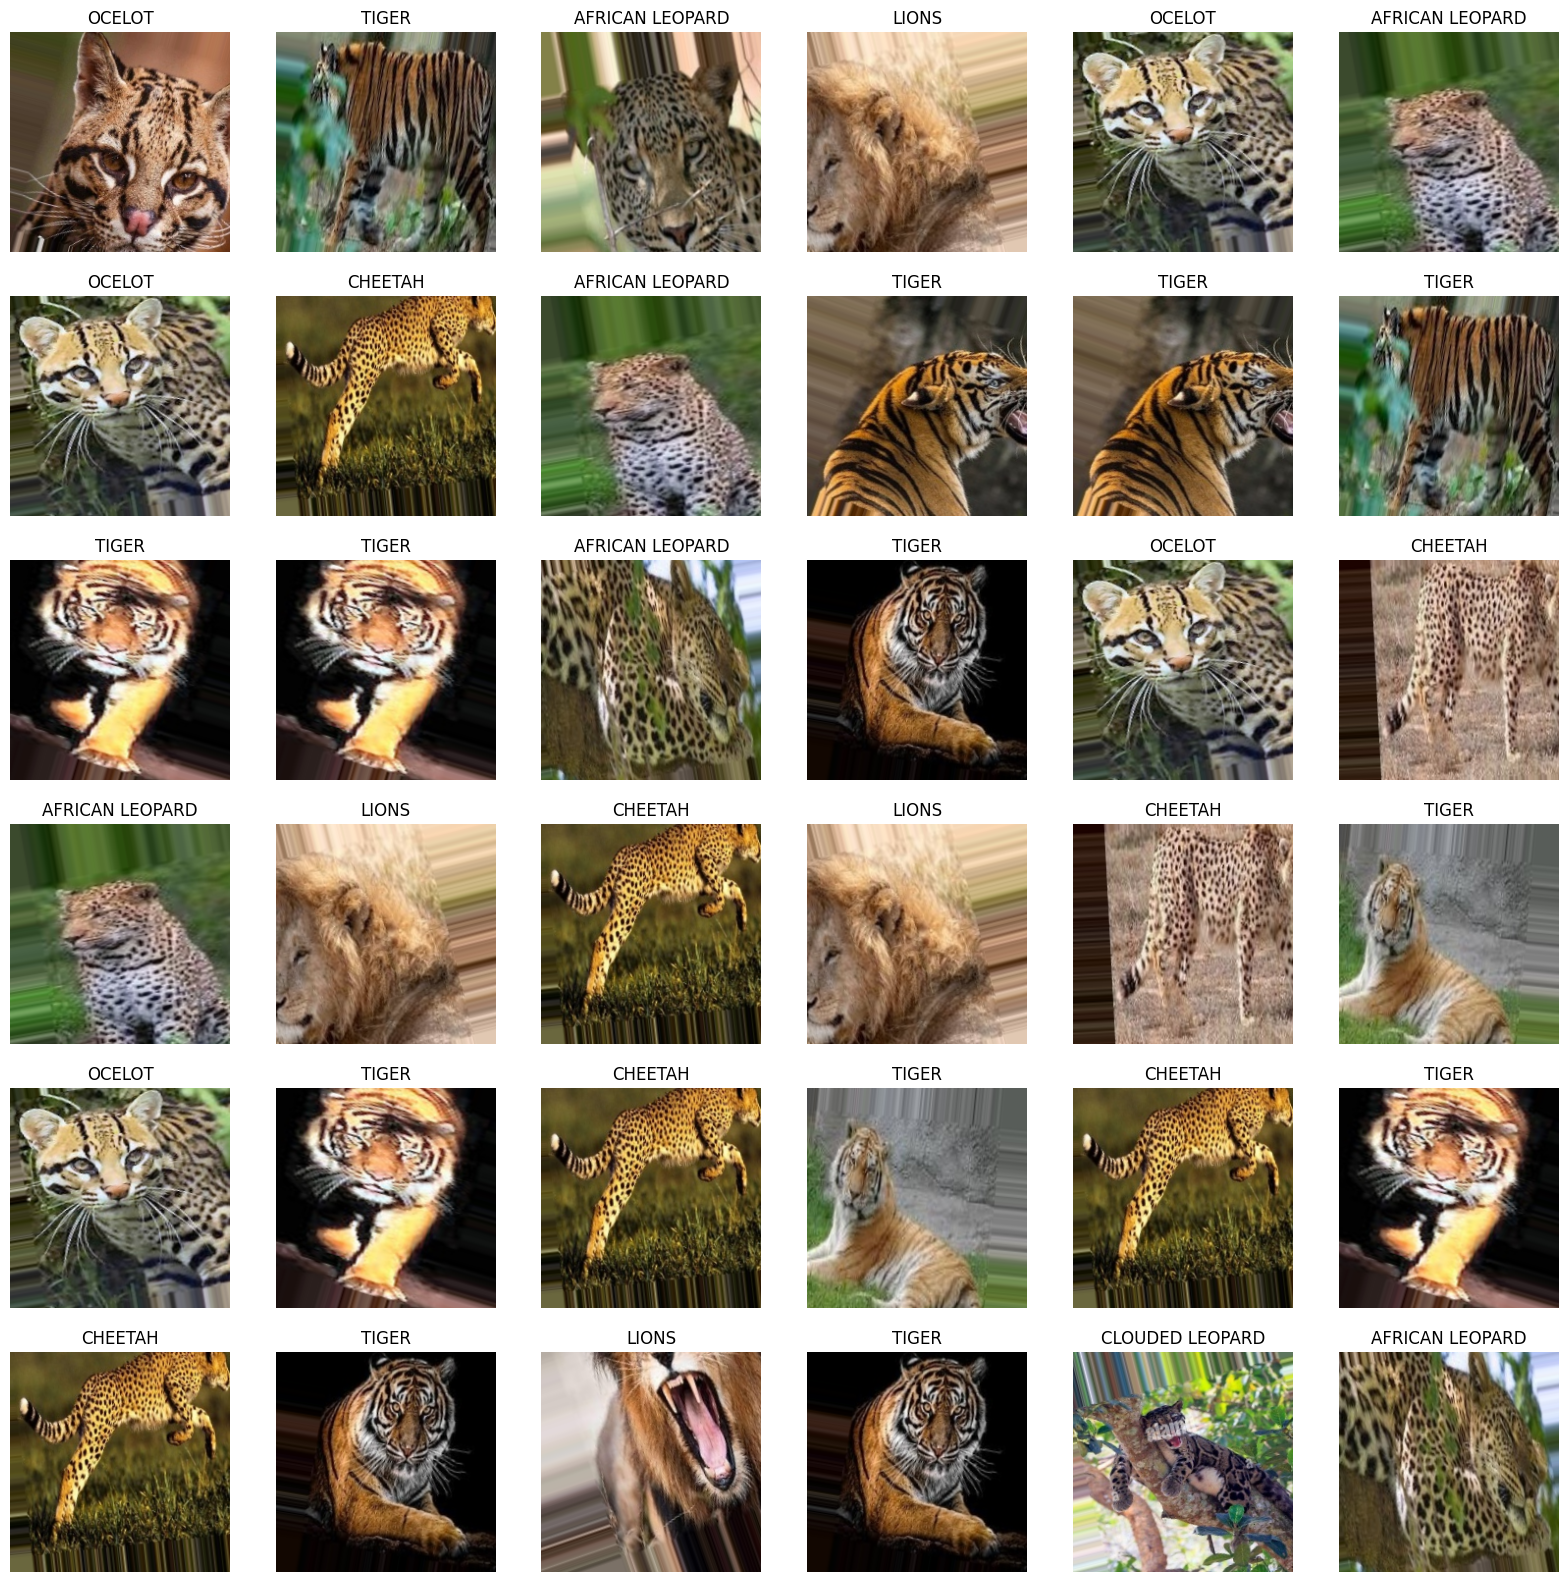

In [12]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

Show_Images(train_generator)

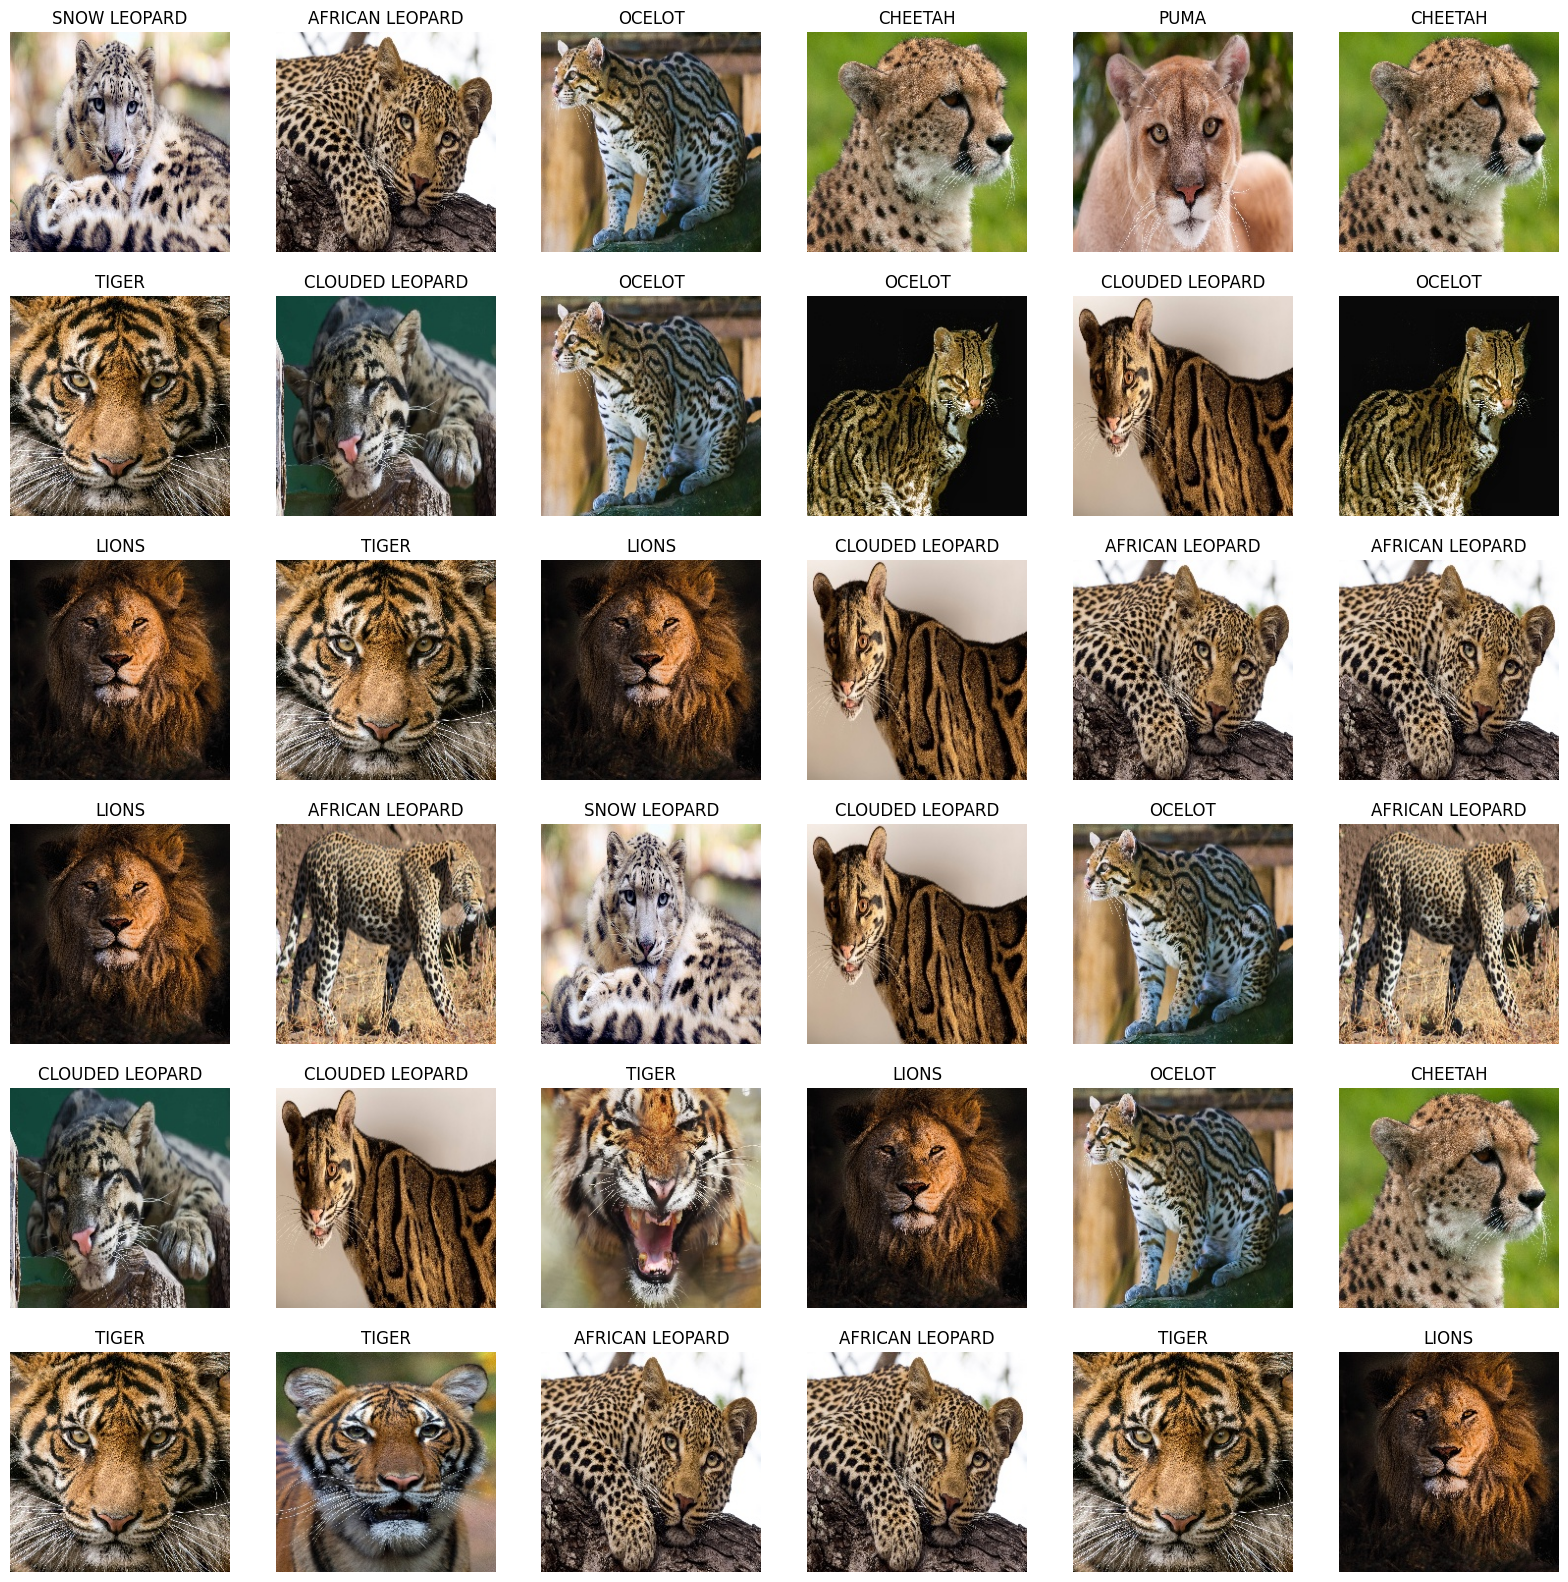

In [13]:
Show_Images(test_generator)

In [14]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [15]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [40]:
from tensorflow.keras import optimizers
from keras.callbacks import LearningRateScheduler

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ 
    #lr_callback ,
      learning_rate_reduce ,early_stopping ]

In [18]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'MobileNetV2',
]

# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator[i]
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [24]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics=['accuracy']
    )
    
    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=20,
        validation_split=0.2,
        batch_size=batch_size
    )
        
    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 695ms/step - accuracy: 0.5339 - loss: 2.1133 - val_accuracy: 0.8267 - val_loss: 0.7717
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 692ms/step - accuracy: 0.8848 - loss: 0.4923 - val_accuracy: 0.8812 - val_loss: 0.6650
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 699ms/step - accuracy: 0.8770 - loss: 0.4432 - val_accuracy: 0.8168 - val_loss: 0.9368
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 703ms/step - accuracy: 0.9116 - loss: 0.3631 - val_accuracy: 0.8762 - val_loss: 0.6766
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 721ms/step - accuracy: 0.9402 - loss: 0.2363 - val_accuracy: 0.8614 - val_loss: 0.6629
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 738ms/step - accuracy: 0.9353 - loss: 0.1973 - val_accuracy: 0.8069 - val_loss: 0.9572
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 740ms/step - accuracy: 0.9336 - loss: 0.2735 - val_accuracy: 0.8515 - val_loss: 0.7416
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 718ms/step - accuracy: 0.9509 - loss: 0.1994 - val_accu

Training Tl Models:  20%|██        | 1/5 [12:10<48:43, 730.99s/it]

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6082 - loss: 1.6683 - val_accuracy: 0.8564 - val_loss: 0.7484
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8843 - loss: 0.5481 - val_accuracy: 0.9059 - val_loss: 0.5269
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9101 - loss: 0.3950 - val_accuracy: 0.8515 - val_loss: 1.0026
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9186 - loss: 0.3212 - val_accuracy: 0.8663 - val_loss: 1.0607
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9396 - loss: 0.2938 - val_accuracy: 0.8812 - val_loss: 0.6235
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9308 - loss: 0.2556 - val_accuracy: 0.9109 - val_loss: 0.7266
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9492 - loss: 0.1679 - val_accuracy: 0.8663 - val_loss: 0.8745
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9579 - loss: 0.1468 - val_accuracy: 0.8861 - val_lo

Training Tl Models:  40%|████      | 2/5 [44:28<1:12:01, 1440.60s/it]

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 366ms/step - accuracy: 0.5548 - loss: 2.4361 - val_accuracy: 0.8168 - val_loss: 0.9334
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.8585 - loss: 0.5394 - val_accuracy: 0.9109 - val_loss: 0.5239
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.8900 - loss: 0.5061 - val_accuracy: 0.9059 - val_loss: 0.7928
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.9162 - loss: 0.3464 - val_accuracy: 0.8614 - val_loss: 1.0098
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.8955 - loss: 0.5311 - val_accuracy: 0.8762 - val_loss: 0.9411
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.9328 - loss: 0.2637 - val_accuracy: 0.8762 - val_loss: 1.0743
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 327ms/step - accuracy: 0.9303 - loss: 0.3028 - val_accuracy: 0.8911 - val_loss: 0.9281
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.9382 - loss: 0.2113 - val_accu

Training Tl Models:  60%|██████    | 3/5 [50:04<31:12, 936.21s/it]   

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 864ms/step - accuracy: 0.6244 - loss: 1.2421 - val_accuracy: 0.8663 - val_loss: 0.4738
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 925ms/step - accuracy: 0.9020 - loss: 0.2984 - val_accuracy: 0.8564 - val_loss: 0.4827
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 986ms/step - accuracy: 0.9119 - loss: 0.2577 - val_accuracy: 0.8812 - val_loss: 0.3511
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 993ms/step - accuracy: 0.9320 - loss: 0.2137 - val_accuracy: 0.9059 - val_loss: 0.3155
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 995ms/step - accuracy: 0.9658 - loss: 0.1459 - val_accuracy: 0.9208 - val_loss: 0.4071
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 978ms/step - accuracy: 0.9577 - loss: 0.1382 - val_accuracy: 0.8861 - val_loss: 0.4753
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 978ms/step - accuracy: 0.9483 - loss: 0.1423 - val_accuracy: 0.9158 - val_loss: 0.3593
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 978ms/step - accuracy: 0.9577 - loss: 0.1200 - val_accu

Training Tl Models:  80%|████████  | 4/5 [1:06:38<15:59, 959.13s/it]

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.5163 - loss: 1.8256 - val_accuracy: 0.8465 - val_loss: 0.5289
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.8333 - loss: 0.6291 - val_accuracy: 0.8861 - val_loss: 0.4826
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - accuracy: 0.8803 - loss: 0.4031 - val_accuracy: 0.8465 - val_loss: 0.5282
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - accuracy: 0.8865 - loss: 0.3519 - val_accuracy: 0.8762 - val_loss: 0.6372
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.9041 - loss: 0.3320 - val_accuracy: 0.9158 - val_loss: 0.5022
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.9439 - loss: 0.2157 - val_accuracy: 0.8911 - val_loss: 0.6249
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.9408 - loss: 0.1732 - val_accuracy: 0.8960 - val_loss: 0.6040
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - accuracy: 0.9307 - loss: 0.2317 - val_accu

Training Tl Models: 100%|██████████| 5/5 [1:11:57<00:00, 863.43s/it]


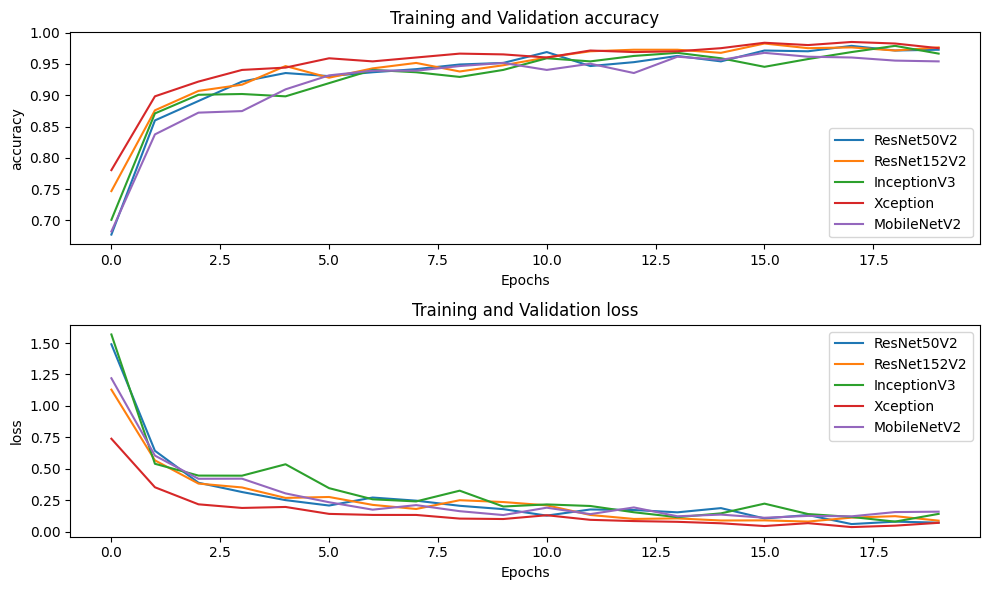

In [37]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [26]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(images_size, images_size, 3))

In [27]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [28]:
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10,activation='softmax'),
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [38]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [41]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=callback
)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 120s 793ms/step - accuracy: 0.6498 - loss: 1.9922 - val_accuracy: 0.9583 - val_loss: 0.1420 - learning_rate: 0.0090
Epoch 2/20


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


  1/146 ━━━━━━━━━━━━━━━━━━━━ 1:46 732ms/step - accuracy: 0.8125 - loss: 0.4121

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.4121 - val_accuracy: 1.0000 - val_loss: 0.0106 - learning_rate: 0.0090
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 781ms/step - accuracy: 0.8260 - loss: 0.5720 - val_accuracy: 0.9583 - val_loss: 0.1185 - learning_rate: 0.0082
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.7500 - loss: 0.8019 - val_accuracy: 1.0000 - val_loss: 0.0551 - learning_rate: 0.0081
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 121s 823ms/step - accuracy: 0.8311 - loss: 0.5534 - val_accuracy: 0.9167 - val_loss: 0.1749 - learning_rate: 0.0074
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.2689 - val_accuracy: 1.0000 - val_loss: 0.0735 - learning_rate: 0.0074
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 121s 822ms/step - accuracy: 0.8396 - loss: 0.5026 - val_accuracy: 0.9375 - val_loss: 0.1722 - learning_rate: 0.0066


In [42]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09530815482139587
Test accuracy: 0.9599999785423279


In [43]:
true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


NameError: name 'confusion_matrix' is not defined

In [ ]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

In [ ]:
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()    
class_names = list(class_names)
num_batches = len(train_generator)
for i in range(10):
    x_batch, y_batch = train_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()